# Carregar dados para a memória

In [1]:
import pandas as pd
from pathlib import Path

# Path to the directory
directory_path = Path('./../../dados')

# Get all files in the directory
files = [f for f in directory_path.iterdir() if f.is_file()]

# df = pd.DataFrame()

# for file in files:
#     print(file.name)
#     aux_df = pd.read_csv(f"{directory_path}/{file.name}", sep=';')
#     df = pd.concat([df, aux_df])

df = pd.read_csv(f"{directory_path}/HIST_PAINEL_COVIDBR_2020_Parte1_18abr2025.csv", sep=";")
df = df.reset_index()

df.head()

,index,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,0.0,0.0,NaN
1,1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,1.0,0.0,NaN
2,2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,1.0,0.0,NaN
3,3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,0.0,1.0,NaN
4,4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,1.0,1.0,NaN


# Remover outliers

Os outliers nos _casosNovos_ impactam os _casosAcumulado_, então removeremos os outliers dos _casosNovos_ e recalcularemos os _casosAcumulado_.

## Exemplo de outlier
No dia 2020-06-04 no Rio de Janeiro os casos foram registrados normalmente.

In [2]:
df.loc[418132]

index                              418132
regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-04
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                      33695
casosNovos                            744
obitosAcumulado                      4231
obitosNovos                           176
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418132, dtype: object

Porém no dia 2020-06-05 tivemos um registro de 1.372.984 casos novos.

In [3]:
df.loc[418133]

index                              418133
regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-05
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                    1408687
casosNovos                        1374992
obitosAcumulado                     38643
obitosNovos                         34412
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418133, dtype: object

E foi removido no dia 2020-06-06

In [4]:
df.loc[418134]

index                              418134
regiao                            Sudeste
estado                                 RJ
municipio                  Rio de Janeiro
coduf                                  33
codmun                           330455.0
codRegiaoSaude                    33005.0
nomeRegiaoSaude           METROPOLITANA I
data                           2020-06-06
semanaEpi                              23
populacaoTCU2019                6718903.0
casosAcumulado                      35703
casosNovos                       -1372984
obitosAcumulado                      4401
obitosNovos                        -34242
Recuperadosnovos                      NaN
emAcompanhamentoNovos                 NaN
interior/metropolitana                1.0
Name: 418134, dtype: object

## Tratando outliers

In [5]:
box_plot_df = pd.melt(df, id_vars=['index'], value_vars=['casosNovos', 'obitosNovos'])

In [6]:
df.columns

Index(['index', 'regiao', 'estado', 'municipio', 'coduf', 'codmun',
       'codRegiaoSaude', 'nomeRegiaoSaude', 'data', 'semanaEpi',
       'populacaoTCU2019', 'casosAcumulado', 'casosNovos', 'obitosAcumulado',
       'obitosNovos', 'Recuperadosnovos', 'emAcompanhamentoNovos',
       'interior/metropolitana'],
      dtype='object')

<Axes: xlabel='value', ylabel='variable'>

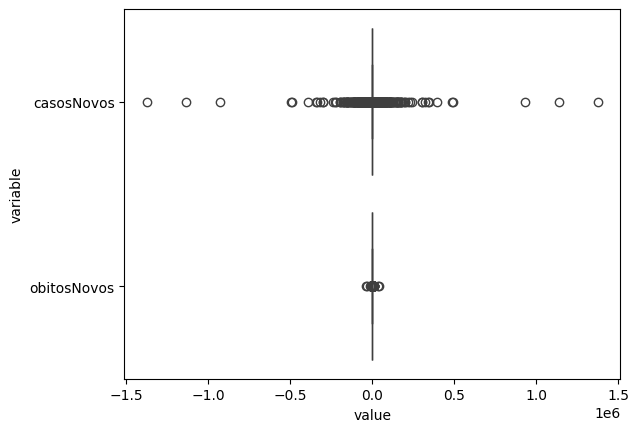

In [7]:
import seaborn as sns

sns.boxplot(data=box_plot_df, x="value", y="variable")

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df["z_score"] = scaler.fit_transform(df[['casosNovos']])

df["z_score"].describe()

count    7.144810e+05
mean     1.586208e-18
std      1.000001e+00
min     -3.167689e+02
25%     -2.579237e-03
50%     -2.579237e-03
75%     -2.348523e-03
max      3.172270e+02
Name: z_score, dtype: float64

Com isso definimos que um limite ideal para corte será de 3.

In [40]:
LIMITE_COMUM = 1

df_sem_outliers = df[abs(df["z_score"]) < LIMITE_COMUM]

print("Antes da remoção de outliers: ", len(df), "| Depois: ", len(df_sem_outliers))
print("Diferença: ", len(df) - len(df_sem_outliers))

Antes da remoção de outliers:  714481 | Depois:  711571
Diferença:  2910


<Axes: title={'center': 'Depois da remoção de outliers'}, xlabel='casosNovos'>

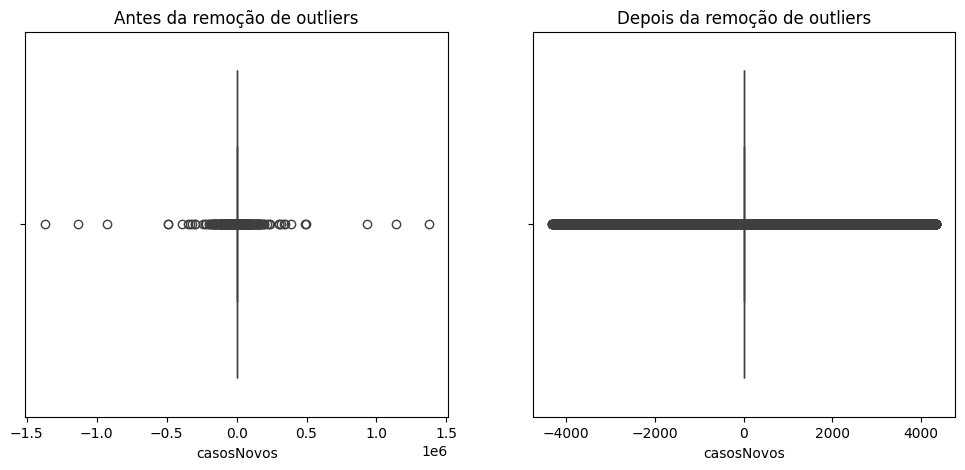

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Antes da remoção de outliers")
sns.boxplot(data=df, x="casosNovos")

plt.subplot(1,2,2)
plt.title("Depois da remoção de outliers")
sns.boxplot(data=df_sem_outliers, x="casosNovos")

### Linha do tempo

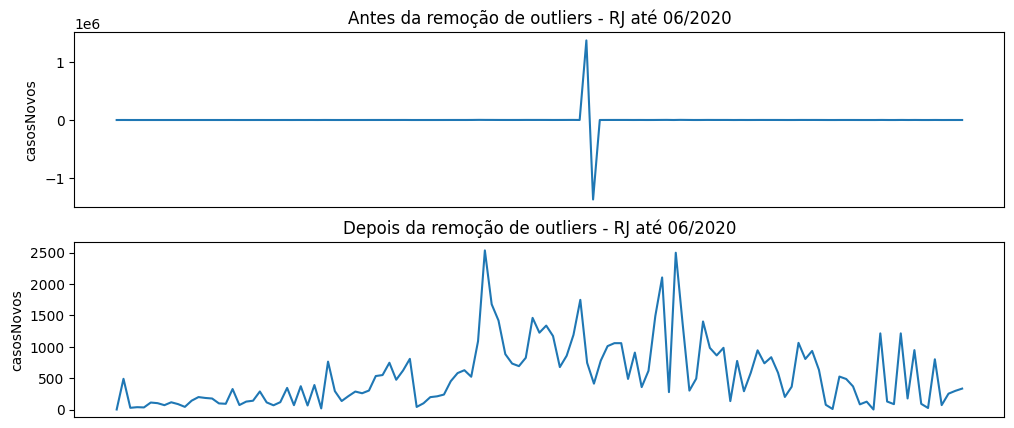

In [42]:
plot_df = df[df['municipio'] == 'Rio de Janeiro']
plot_df_sem_outliers = df_sem_outliers[df_sem_outliers['municipio'] == 'Rio de Janeiro']

def plot_comparacao_outliers(df1, df2, label1, label2):
  plt.figure(figsize=(12,5))
  plt.subplot(2,1,1)
  plt.title(label1)
  sns.lineplot(data=df1, y="casosNovos", x='data')
  plt.xticks([])
  plt.xlabel("")

  plt.subplot(2,1,2)
  plt.title(label2)
  sns.lineplot(data=df2, y="casosNovos", x='data')
  plt.xticks([])
  plt.xlabel("")

plot_comparacao_outliers(plot_df, plot_df_sem_outliers, "Antes da remoção de outliers - RJ até 06/2020", "Depois da remoção de outliers - RJ até 06/2020")

### Plot outliers

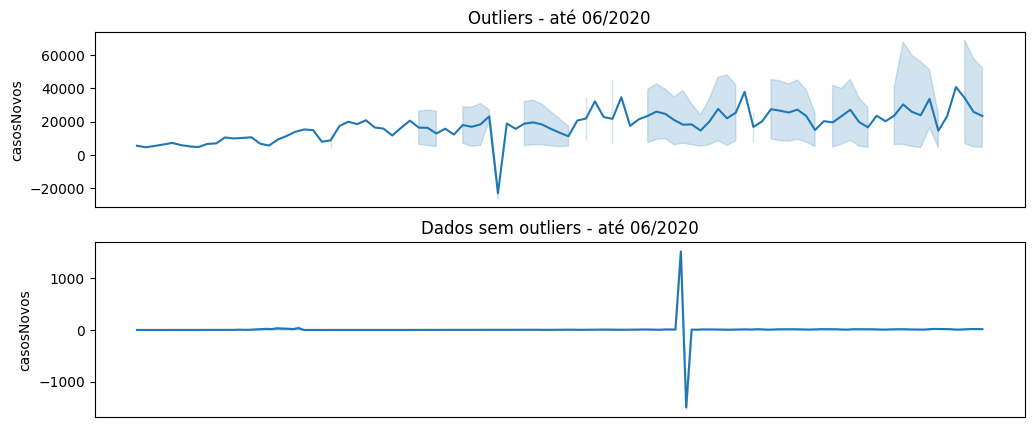

In [43]:
df_outliers = df[abs(df["z_score"]) >= LIMITE_COMUM]

plot_comparacao_outliers(df_outliers, df_sem_outliers, "Outliers - até 06/2020", "Dados sem outliers - até 06/2020")

### Casos negativos

In [ ]:
len(df_sem_outliers[df_sem_outliers['casosNovos'] < 0])

11444

In [55]:
contagem_de_valores_negativos = df_sem_outliers[df_sem_outliers['casosNovos'] < 0].sort_values(by='casosNovos', ascending=False).casosNovos.value_counts().reset_index()

contagem_de_valores_negativos[contagem_de_valores_negativos['count'] == 1].sort_values(by='casosNovos')

,casosNovos,count
1531,-4323,1
2432,-4318,1
2431,-4314,1
2430,-4312,1
2429,-4307,1
...,...,...
2401,-49,1
1540,-46,1
1538,-45,1
1536,-44,1


### Notas

Percebemos que continuam muitos outliers e precisamos de uma estrategia para remover mais efetivamente esses outliers.

Para isso, chegamos na conclusão que podemos utilizar uma janela deslizante calculando sua média e se o valor for muito maior que um limite, repete-se o ultimo valor.

# Recalcular casos acumulados